In [1]:
import pandas as pd
import numpy as np

import yfinance as yf
import datetime as dt

from matplotlib import pyplot as plt

In [2]:
start = dt.datetime(2010,1,1)
end = dt.datetime(2020,12,31)

In [3]:
# List all relevant stocks
symbols = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'V']

In [4]:
def download_stock_data(symbol):
    """Downloads historical stock pricing data for an individual symbol"""

    df = pd.DataFrame()  

    # Print the symbol being downloaded
    print('DOWNLOADING ' + symbol, sep=',', end=' ... ', flush=True)  

    try:
        # Download pricing data
        stock = []
        stock = yf.download(symbol, start=start, end=end, progress=False)

        # Append individual prices
        if len(stock) == 0:
            None
        else:
            stock['Name'] = symbol
            df = df.append(stock,sort=False)
            df = df[['Close', 'Name']]
            print('SUCCESS!')
            
    except Exception:
        print('ERROR IN DOWNLOADING DATA')
               
    return df



def day_change_transitions(df):
    """Calculates a measure of change from good/middle/bad days sto good/middle/bad."""
    
    # Controls
    num_days = 100
    min_change = 0.001
    
    # How has the stock performed in the last X days?
    df[str(num_days)+'D Change'] = df['Close'] - df.loc[:,'Close'].shift(num_days)
    df[str(num_days)+'D Change Switch'] = np.where(df[str(num_days)+'D Change'] > 0, True, False)

    # Is the change significant?
    df['Change Percent Value'] = np.absolute(df[str(num_days)+'D Change'] / df['Close'])
    df['Change Percent Value Switch'] = np.where(df['Change Percent Value'] > min_change, True, False)

    # Combine everything
    conditions = [
        (df[str(num_days)+'D Change Switch'] == True) & (df['Change Percent Value Switch'] == True),
        (df[str(num_days)+'D Change Switch'] == False) & (df['Change Percent Value Switch'] == True),
        (df['Change Percent Value Switch'] == False)]
    
    # Assign categories
    choices = [0, 1, 2]
    df['Output'] = np.select(conditions, choices, default = 2)
    
    # Isolate transitions
    transitions = list(df['Output'])[num_days:]

    # Plot it because it pretty
    ##df[['Close', str(num_days)+'D Change']].plot()
    ##plt.show()
    
    return transitions



def generate_transition_matrix(l):
    """Generates a transition matrix from a list of data"""
    
    # Identify all unique elements and create an empty transition matrix
    elements = list(set(l))
    elements_len = len(elements)
    transition_matrix = [[0] * elements_len for x in range(elements_len)]

    # Create a zipped pair of each state and its next, and then a transition matrix
    for (i,j) in zip(l,l[1:]):
        transition_matrix[i][j] += 1
    for i in transition_matrix:
        if sum(i) > 0:
            i[:] = [x/sum(i) for x in i]
    
    # Print transition matrix
    for _ in transition_matrix:
        print([np.around(x, 4) for x in _])
    
    return transition_matrix



def generate_combine_transition_matrices(symbols):
    """Runs each part of the progrm for each symbol and combines the transition matrices"""
    
    list_tm = []
    
    # Generate transition matrix for each symbol
    for i in symbols:
        df = download_stock_data(i)
        transitions = day_change_transitions(df)
        transition_matrix = generate_transition_matrix(transitions)
        list_tm.append(transition_matrix)
    
    # Average transition matrix for each symbol, this still satisfies Kolmogorov axioms
    first = True
    for _ in list_tm:
        if first == True:
            avg_tm = np.array(_)
            first = False
        else:
            avg_tm = avg_tm + np.array(_)
    avg_tm = avg_tm / len(list_tm)
    
    # Pretty print
    printable_tm = [list(x) for x in avg_tm]
    print('\nALL STOCKS TRANSITION MATRIX')
    for _ in printable_tm:
        print([np.around(x, 4) for x in _])
    
    return avg_tm



def stationary_values(transition_matrix, mmult_number = 50):
    """From a transition matrix, generate stationary values"""
        
    # Create a 1st state array
    state = np.array([[0.0] * len(transition_matrix)])
    state[0][0] = 1.0
    
    # Create a state tracker
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = [[0,0]]
    
    # Calculate stationary values
    for x in range(mmult_number):
        state = np.dot(state,transition_matrix)
        stateHist = np.append(stateHist,state,axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
    svals = dfDistrHist[-1:].iloc[0]
    
    # Plot the descent to stationary
    dfDistrHist.plot()
    plt.show()
        
    return svals

DOWNLOADING AAPL ... SUCCESS!
[0.985, 0.0131, 0.0019]
[0.0419, 0.9513, 0.0067]
[0.6667, 0.2222, 0.1111]
DOWNLOADING MSFT ... SUCCESS!
[0.9748, 0.0218, 0.0035]
[0.0706, 0.9246, 0.0047]
[0.7, 0.3, 0.0]
DOWNLOADING GOOG ... SUCCESS!
[0.9683, 0.0291, 0.0026]
[0.0724, 0.918, 0.0096]
[0.75, 0.25, 0.0]
DOWNLOADING TSLA ... SUCCESS!
[0.9628, 0.0372, 0.0]
[0.0685, 0.9269, 0.0046]
[0.5, 0.5, 0.0]
DOWNLOADING V ... SUCCESS!
[0.9759, 0.0214, 0.0027]
[0.1031, 0.886, 0.011]
[0.5833, 0.3333, 0.0833]

ALL STOCKS TRANSITION MATRIX
[0.9733, 0.0245, 0.0021]
[0.0713, 0.9214, 0.0073]
[0.64, 0.3211, 0.0389]


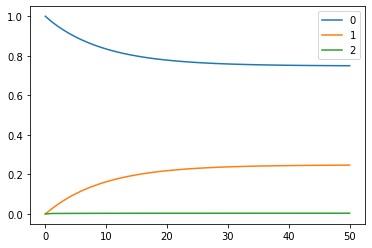

0    0.749653
1    0.246798
2    0.003549
Name: 50, dtype: float64

In [5]:
avg_tm = generate_combine_transition_matrices(symbols)
stationary_values(avg_tm)